<a href="https://colab.research.google.com/github/Nishant-Ramakuru/Inference-based-GNNS/blob/main/simulations/Generate_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install -q git+https://www.github.com/google/jax-md

In [27]:
class Vehicle():

    def __init__(self, x, y):
        self.acceleration = PVector(0, 0)
        self.velocity = PVector(0, -2)
        self.position = PVector(x, y)
        self.r = 6
        self.maxspeed = 8
        self.maxforce = 0.2

    # Method to update location
    def update(self):
        # Update velocity
        self.velocity.add(self.acceleration)
        # Limit speed
        self.velocity.limit(self.maxspeed)
        self.position.add(self.velocity)
        # Reset accelerationelertion to 0 each cycle
        self.acceleration.mult(0)

    def applyForce(self, force):
        # We could add mass here if we want A = F / M
        self.acceleration.add(force)

    # A method that calculates a steering force towards a target
    # STEER = DESIRED MINUS VELOCITY
    def seek(self, target):

        # A vector pointing from the location to the target
        desired = target - self.position

        # Scale to maximum speed
        desired.setMag(self.maxspeed)

        steer = desired - self.velocity
        steer.limit(self.maxforce)  # Limit to maximum steering force

        self.applyForce(steer)

    def display(self):
        # Draw a triangle rotated in the direction of velocity
        theta = self.velocity.heading() + PI / 2
        fill(127)
        stroke(200)
        strokeWeight(1)
        with pushMatrix():
            translate(self.position.x, self.position.y)
            rotate(theta)
            beginShape()
            vertex(0, -self.r * 2)
            vertex(-self.r, self.r * 2)
            vertex(self.r, self.r * 2)
            endShape(CLOSE)

In [28]:
import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import vmap
from jax import lax
vectorize = np.vectorize

from functools import partial

from collections import namedtuple
import base64

import IPython
from google.colab import output

import os

from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util
from jax_md.util import f32

# Plotting

import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

dark_color = [56 / 256] * 3
light_color = [213 / 256] * 3
axis_color = 'white'

def format_plot(x='', y='', grid=True):  
  ax = plt.gca()
  
  ax.spines['bottom'].set_color(axis_color)
  ax.spines['top'].set_color(axis_color) 
  ax.spines['right'].set_color(axis_color)
  ax.spines['left'].set_color(axis_color)
  
  ax.tick_params(axis='x', colors=axis_color)
  ax.tick_params(axis='y', colors=axis_color)
  ax.yaxis.label.set_color(axis_color)
  ax.xaxis.label.set_color(axis_color)
  ax.set_facecolor(dark_color)
  
  plt.grid(grid)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().patch.set_facecolor(dark_color)
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Progress Bars

from IPython.display import HTML, display
import time


def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

normalize = lambda v: v / np.linalg.norm(v, axis=1, keepdims=True)

# Rendering

renderer_code = IPython.display.HTML('''
<canvas id="canvas"></canvas>
<script>
  Rg = null;
  Ng = null;

  var current_scene = {
      R: null,
      N: null,
      is_loaded: false,
      frame: 0,
      frame_count: 0,
      boid_vertex_count: 0,
      boid_buffer: [],
      predator_vertex_count: 0,
      predator_buffer: [],
      disk_vertex_count: 0,
      disk_buffer: null,
      box_size: 0
  };

  google.colab.output.setIframeHeight(0, true, {maxHeight: 5000});

  async function load_simulation() {
    buffer_size = 400;
    max_frame = 800;

    result = await google.colab.kernel.invokeFunction(
        'notebook.GetObstacles', [], {});
    data = result.data['application/json'];

    if(data.hasOwnProperty('Disk')) {
      current_scene = put_obstacle_disk(current_scene, data.Disk);
    }

    for (var i = 0 ; i < max_frame ; i += buffer_size) {
      console.log(i);
      result = await google.colab.kernel.invokeFunction(
          'notebook.GetBoidStates', [i, i + buffer_size], {}); 
      
      data = result.data['application/json'];
      current_scene = put_boids(current_scene, data);
    }
    current_scene.is_loaded = true;

    result = await google.colab.kernel.invokeFunction(
        'notebook.GetPredators', [], {}); 
    data = result.data['application/json'];
    if (data.hasOwnProperty('R'))
      current_scene = put_predators(current_scene, data);

    result = await google.colab.kernel.invokeFunction(
          'notebook.GetSimulationInfo', [], {});
    current_scene.box_size = result.data['application/json'].box_size;
  }

  function initialize_gl() {
    const canvas = document.getElementById("canvas");
    canvas.width = 640;
    canvas.height = 640;

    const gl = canvas.getContext("webgl2");

    if (!gl) {
        alert('Unable to initialize WebGL.');
        return;
    }

    gl.viewport(0, 0, gl.drawingBufferWidth, gl.drawingBufferHeight);
    gl.clearColor(0.2, 0.2, 0.2, 1.0);
    gl.enable(gl.DEPTH_TEST);

    const shader_program = initialize_shader(
        gl, VERTEX_SHADER_SOURCE_2D, FRAGMENT_SHADER_SOURCE_2D);
    const shader = {
      program: shader_program,
      attribute: {
          vertex_position: gl.getAttribLocation(shader_program, 'vertex_position'),
      },
      uniform: {
          screen_position: gl.getUniformLocation(shader_program, 'screen_position'),
          screen_size: gl.getUniformLocation(shader_program, 'screen_size'),
          color: gl.getUniformLocation(shader_program, 'color'),
      },
    };
    gl.useProgram(shader_program);

    const half_width = 200.0;

    gl.uniform2f(shader.uniform.screen_position, half_width, half_width);
    gl.uniform2f(shader.uniform.screen_size, half_width, half_width);
    gl.uniform4f(shader.uniform.color, 0.9, 0.9, 1.0, 1.0);

    return {gl: gl, shader: shader};
  }

  var loops = 0;

  function update_frame() {
    gl.clear(gl.COLOR_BUFFER_BIT | gl.DEPTH_BUFFER_BIT);

    if (!current_scene.is_loaded) {
      window.requestAnimationFrame(update_frame);
      return;
    }

    var half_width = current_scene.box_size / 2.;
    gl.uniform2f(shader.uniform.screen_position, half_width, half_width);
    gl.uniform2f(shader.uniform.screen_size, half_width, half_width);

    if (current_scene.frame >= current_scene.frame_count) {
      if (!current_scene.is_loaded) {
        window.requestAnimationFrame(update_frame);
        return;
      }
      loops++;
      current_scene.frame = 0;
    }

    gl.enableVertexAttribArray(shader.attribute.vertex_position);

    gl.bindBuffer(gl.ARRAY_BUFFER, current_scene.boid_buffer[current_scene.frame]);
    gl.uniform4f(shader.uniform.color, 0.0, 0.35, 1.0, 1.0);
    gl.vertexAttribPointer(
      shader.attribute.vertex_position,
      2,
      gl.FLOAT,
      false,
      0,
      0
    );
    gl.drawArrays(gl.TRIANGLES, 0, current_scene.boid_vertex_count);

    if(current_scene.predator_buffer.length > 0)  {
      gl.bindBuffer(gl.ARRAY_BUFFER, current_scene.predator_buffer[current_scene.frame]);
      gl.uniform4f(shader.uniform.color, 1.0, 0.35, 0.35, 1.0);
      gl.vertexAttribPointer(
        shader.attribute.vertex_position,
        2,
        gl.FLOAT,
        false,
        0,
        0
      );
      gl.drawArrays(gl.TRIANGLES, 0, current_scene.predator_vertex_count);
    }
    
    if(current_scene.disk_buffer) {
      gl.bindBuffer(gl.ARRAY_BUFFER, current_scene.disk_buffer);
      gl.uniform4f(shader.uniform.color, 0.9, 0.9, 1.0, 1.0);
      gl.vertexAttribPointer(
        shader.attribute.vertex_position,
        2,
        gl.FLOAT,
        false,
        0,
        0
      );
      gl.drawArrays(gl.TRIANGLES, 0, current_scene.disk_vertex_count);
    }

    current_scene.frame++;
    if ((current_scene.frame_count > 1 && loops < 5) || 
        (current_scene.frame_count == 1 && loops < 240))
      window.requestAnimationFrame(update_frame);
    
    if (current_scene.frame_count > 1 && loops == 5 && current_scene.frame < current_scene.frame_count - 1)
      window.requestAnimationFrame(update_frame);
  }

  function put_boids(scene, boids) {
    const R = decode(boids['R']);
    const R_shape = boids['R_shape'];
    const theta = decode(boids['theta']);
    const theta_shape = boids['theta_shape'];

    function index(i, b, xy) {
      return i * R_shape[1] * R_shape[2] + b * R_shape[2] + xy; 
    }

    var steps = R_shape[0];
    var boids = R_shape[1];
    var dimensions = R_shape[2];

    if(dimensions != 2) {
      alert('Can only deal with two-dimensional data.')
    }

    // First flatten the data.
    var buffer_data = new Float32Array(boids * 6);
    var size = 8.0;
    for (var i = 0 ; i < steps ; i++) {
      var buffer = gl.createBuffer();
      for (var b = 0 ; b < boids ; b++) {
        var xi = index(i, b, 0);
        var yi = index(i, b, 1);
        var ti = i * boids + b;
        var Nx = size * Math.cos(theta[ti]); //N[xi];
        var Ny = size * Math.sin(theta[ti]); //N[yi];
        buffer_data.set([
          R[xi] + Nx, R[yi] + Ny,
          R[xi] - Nx - 0.5 * Ny, R[yi] - Ny + 0.5 * Nx,
          R[xi] - Nx + 0.5 * Ny, R[yi] - Ny - 0.5 * Nx,             
        ], b * 6);
      }
      gl.bindBuffer(gl.ARRAY_BUFFER, buffer);
      gl.bufferData(gl.ARRAY_BUFFER, buffer_data, gl.STATIC_DRAW);

      scene.boid_buffer.push(buffer);
    }
    scene.boid_vertex_count = boids * 3;
    scene.frame_count += steps;
    return scene;
  }

  function put_predators(scene, boids) {
    // TODO: Unify this with the put_boids function.
    const R = decode(boids['R']);
    const R_shape = boids['R_shape'];
    const theta = decode(boids['theta']);
    const theta_shape = boids['theta_shape'];

    function index(i, b, xy) {
      return i * R_shape[1] * R_shape[2] + b * R_shape[2] + xy; 
    }

    var steps = R_shape[0];
    var boids = R_shape[1];
    var dimensions = R_shape[2];

    if(dimensions != 2) {
      alert('Can only deal with two-dimensional data.')
    }

    // First flatten the data.
    var buffer_data = new Float32Array(boids * 6);
    var size = 18.0;
    for (var i = 0 ; i < steps ; i++) {
      var buffer = gl.createBuffer();
      for (var b = 0 ; b < boids ; b++) {
        var xi = index(i, b, 0);
        var yi = index(i, b, 1);
        var ti = theta_shape[1] * i + b;
        var Nx = size * Math.cos(theta[ti]);
        var Ny = size * Math.sin(theta[ti]);
        buffer_data.set([
          R[xi] + Nx, R[yi] + Ny,
          R[xi] - Nx - 0.5 * Ny, R[yi] - Ny + 0.5 * Nx,
          R[xi] - Nx + 0.5 * Ny, R[yi] - Ny - 0.5 * Nx,             
        ], b * 6);
      }
      gl.bindBuffer(gl.ARRAY_BUFFER, buffer);
      gl.bufferData(gl.ARRAY_BUFFER, buffer_data, gl.STATIC_DRAW);

      scene.predator_buffer.push(buffer);
    }
    scene.predator_vertex_count = boids * 3;
    return scene;
  }

  function put_obstacle_disk(scene, disk) {
    const R = decode(disk.R);
    const R_shape = disk.R_shape;
    const radius = decode(disk.D);
    const radius_shape = disk.D_shape;

    const disk_count = R_shape[0];
    const dimensions = R_shape[1];
    if (dimensions != 2) {
        alert('Can only handle two-dimensional data.');
    }
    if (radius_shape[0] != disk_count) {
        alert('Inconsistent disk radius count found.');
    }
    const segments = 32;

    function index(o, xy) {
        return o * R_shape[1] + xy;
    }

    // TODO(schsam): Use index buffers here.
    var buffer_data = new Float32Array(disk_count * segments * 6);
    for (var i = 0 ; i < disk_count ; i++) {
      var xi = index(i, 0);
      var yi = index(i, 1);
      for (var s = 0 ; s < segments ; s++) {
        const th = 2 * s / segments * Math.PI;
        const th_p = 2 * (s + 1) / segments * Math.PI;
        const rad = radius[i] * 0.8;
        buffer_data.set([
          R[xi], R[yi],
          R[xi] + rad * Math.cos(th), R[yi] + rad * Math.sin(th),
          R[xi] + rad * Math.cos(th_p), R[yi] + rad * Math.sin(th_p),
        ], i * segments * 6 + s * 6);
      }
    }
    var buffer = gl.createBuffer();
    gl.bindBuffer(gl.ARRAY_BUFFER, buffer);
    gl.bufferData(gl.ARRAY_BUFFER, buffer_data, gl.STATIC_DRAW);
    scene.disk_vertex_count = disk_count * segments * 3;
    scene.disk_buffer = buffer;
    return scene;
  }

  // SHADER CODE

  const VERTEX_SHADER_SOURCE_2D = `
    // Vertex Shader Program.
    attribute vec2 vertex_position;
    
    uniform vec2 screen_position;
    uniform vec2 screen_size;

    void main() {
      vec2 v = (vertex_position - screen_position) / screen_size;
      gl_Position = vec4(v, 0.0, 1.0);
    }
  `;

  const FRAGMENT_SHADER_SOURCE_2D = `
    precision mediump float;

    uniform vec4 color;

    void main() {
      gl_FragColor = color;
    }
  `;

  function initialize_shader(
    gl, vertex_shader_source, fragment_shader_source) {

    const vertex_shader = compile_shader(
      gl, gl.VERTEX_SHADER, vertex_shader_source);
    const fragment_shader = compile_shader(
      gl, gl.FRAGMENT_SHADER, fragment_shader_source);

    const shader_program = gl.createProgram();
    gl.attachShader(shader_program, vertex_shader);
    gl.attachShader(shader_program, fragment_shader);
    gl.linkProgram(shader_program);

    if (!gl.getProgramParameter(shader_program, gl.LINK_STATUS)) {
      alert(
        'Unable to initialize shader program: ' + 
        gl.getProgramInfoLog(shader_program)
        );
        return null;
    }
    return shader_program;
  }

  function compile_shader(gl, type, source) {
    const shader = gl.createShader(type);
    gl.shaderSource(shader, source);
    gl.compileShader(shader);

    if (!gl.getShaderParameter(shader, gl.COMPILE_STATUS)) {
      alert('An error occured compiling shader: ' + gl.getShaderInfoLog(shader));
      gl.deleteShader(shader);
      return null;
    }

    return shader;
  }

  // SERIALIZATION UTILITIES
  function decode(sBase64, nBlocksSize) {
    var chrs = atob(atob(sBase64));
    var array = new Uint8Array(new ArrayBuffer(chrs.length));

    for(var i = 0 ; i < chrs.length ; i++) {
      array[i] = chrs.charCodeAt(i);
    }

    return new Float32Array(array.buffer);
  }

  // RUN CELL

  load_simulation();
  gl_and_shader = initialize_gl();
  var gl = gl_and_shader.gl;
  var shader = gl_and_shader.shader;
  update_frame();
</script>
''')

def encode(R):
  return base64.b64encode(onp.array(R, onp.float32).tobytes())

def render(box_size, states, obstacles=None, predators=None):
  if isinstance(states, Boids):
    R = np.reshape(states.R, (1,) + states.R.shape)
    theta = np.reshape(states.theta, (1,) + states.theta.shape)
  elif isinstance(states, list):
    if all([isinstance(x, Boids) for x in states]):
      R, theta = zip(*states)
      R = onp.stack(R)
      theta = onp.stack(theta)    
  
  if isinstance(predators, list):
    R_predators, theta_predators, *_ = zip(*predators)
    R_predators = onp.stack(R_predators)
    theta_predators = onp.stack(theta_predators)

  def get_boid_states(start, end):
    R_, theta_ = R[start:end], theta[start:end]
    return IPython.display.JSON(data={
        "R_shape": R_.shape,
        "R": encode(R_), 
        "theta_shape": theta_.shape,
        "theta": encode(theta_)
        })
  output.register_callback('notebook.GetBoidStates', get_boid_states)

  def get_obstacles():
    if obstacles is None:
      return IPython.display.JSON(data={})
    else:
      return IPython.display.JSON(data={
          'Disk': {
              'R': encode(obstacles.R),
              'R_shape': obstacles.R.shape,
              'D': encode(obstacles.D),
              'D_shape': obstacles.D.shape
          }
      })
  output.register_callback('notebook.GetObstacles', get_obstacles)

  def get_predators():
    if predators is None:
      return IPython.display.JSON(data={})
    else:
      return IPython.display.JSON(data={
          'R': encode(R_predators),
          'R_shape': R_predators.shape,
          'theta': encode(theta_predators),
          'theta_shape': theta_predators.shape
      })
  output.register_callback('notebook.GetPredators', get_predators)

  def get_simulation_info():
    return IPython.display.JSON(data={
        'frames': R.shape[0],
        'box_size': box_size
        })
  output.register_callback('notebook.GetSimulationInfo', get_simulation_info)

  return renderer_code

In [29]:
Boids = namedtuple('Boids', ['R', 'theta'])

In [30]:
def align_fn(dR, N_1, N_2, J_align, D_align, alpha):
  dR = lax.stop_gradient(dR)
  dr = space.distance(dR) / D_align
  energy = J_align / alpha * (1. - dr) ** alpha * (1 - np.dot(N_1, N_2)) ** 2
  return np.where(dr < 1.0, energy, 0.)

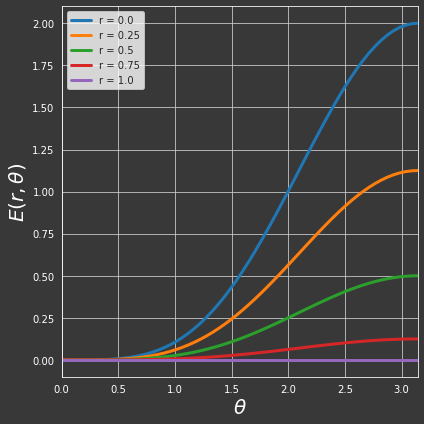

In [31]:
#@title Alignment Energy
N_1 = np.array([1.0, 0.0])
angles = np.linspace(0, np.pi, 60)
N_2 = vmap(lambda theta: np.array([np.cos(theta), np.sin(theta)]))(angles)
distances = np.linspace(0, 1, 5)
dRs = vmap(lambda r: np.array([r, 0.]))(distances)

fn = partial(align_fn, J_align=1., D_align=1., alpha=2.)
energy = vmap(vmap(fn, (None, None, 0)), (0, None, None))(dRs, N_1, N_2)

for d, e in zip(distances, energy):
  plt.plot(angles, e, label='r = {}'.format(d), linewidth=3)

plt.xlim([0, np.pi])
format_plot('$\\theta$', '$E(r, \\theta)$')
plt.legend()
finalize_plot()

In [32]:
def avoid_fn(dR, J_avoid, D_avoid, alpha):
  dr = space.distance(dR) / D_avoid
  return np.where(dr < 1., 
                  J_avoid / alpha * (1 - dr) ** alpha, 
                  0.)

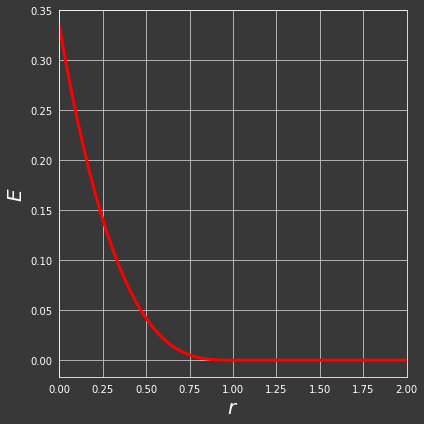

In [33]:
#@title Avoidance Energy

dr = np.linspace(0, 2., 60)
dR = vmap(lambda r: np.array([0., r]))(dr)
Es = vmap(partial(avoid_fn, J_avoid=1., D_avoid=1., alpha=3.))(dR)
plt.plot(dr, Es, 'r', linewidth=3)

plt.xlim([0, 2])

format_plot('$r$', '$E$')
finalize_plot()

We can now run a version of our simulation with both alignment and avoidance. 

Now the boids travel in tighter, more cohesive, packs. By tuning the range of the cohesive interaction and its strength you can change how strongly the boids attempt to stick together. However, if we raise it too high it can have some undesireable consequences.

### Looking Ahead

In [34]:
def field_of_view_mask(dR, N, theta_min, theta_max):
  dr = space.distance(dR)
  dR_hat = dR / dr
  ctheta = np.dot(dR_hat, N)
  # Cosine is monotonically decreasing on [0, pi].
  return np.logical_and(ctheta > np.cos(theta_max),
                      
                        ctheta < np.cos(theta_min))

In [35]:
def cohesion_fn(dR, N, mask, # New mask parameter.
                J_cohesion, D_cohesion, eps=1e-7):
  dR = lax.stop_gradient(dR)
  dr = space.distance(dR)

  mask = np.reshape(mask, mask.shape + (1,))
  dr = np.reshape(dr, dr.shape + (1,))
  
  # Updated Masking Code
  mask = np.logical_and(dr < D_cohesion, mask)
  #
  
  N_com = np.where(mask, 1.0, 0)
  dR_com = np.where(mask, dR, 0)
  dR_com = np.sum(dR_com, axis=1) / (np.sum(N_com, axis=1) + eps)
  dR_com = dR_com / np.linalg.norm(dR_com + eps, axis=1, keepdims=True)
  return f32(0.5) * J_cohesion * (1 - np.sum(dR_com * N, axis=1)) ** 2

In [36]:
Obstacle = namedtuple('Obstacle', ['R', 'D'])

Then we can instantiate some obstacles.

In [37]:
def obstacle_fn(dR, N, D, J_obstacle):
  dr = space.distance(dR)
  dR = dR / np.reshape(dr, dr.shape + (1,))
  return np.where(dr < D,
                  J_obstacle * (1 - dr / D) ** 2 * (1 + np.dot(N, dR)) ** 2,
                  0.)


In [38]:
def boid_predator_fn(R_boid, N_boid, R_predator, J, D, alpha):
  N = N_boid
  dR = displacement(lax.stop_gradient(R_predator), R_boid)
  dr = np.linalg.norm(dR, keepdims=True)
  dR_hat = dR / dr
  return np.where(dr < D,
                  J / alpha * (1 - dr / D) ** alpha * (1 + np.dot(dR_hat, N)),
                  0.)

In [39]:
def predator_boid_fn(R_predator, N_predator, R_boids, J, D, eps=1e-7):
  # It is most convenient to define the predator_boid energy function
  # for a single predator and a whole flock of boids. As such we expect shapes,
  #   R_predator : (spatial_dim,)
  #   N_predator : (spatial_dim,)
  #   R_boids    : (n, spatial_dim,)
  
  N = N_predator 

  # As such, we need to vectorize over the boids.
  d = vmap(displacement, (0, None))
  dR = d(lax.stop_gradient(R_boids), R_predator)
  dr = space.distance(dR)

  fov = partial(field_of_view_mask, 
                theta_min=0.,
                theta_max=np.pi / 3.)
  # Here as well.
  fov = vmap(fov, (0, None))

  mask = np.logical_and(dr < D, fov(dR, N))
  mask = mask[:, np.newaxis]

  boid_count = np.where(mask, 1.0, 0)
  dR_com = np.where(mask, dR, 0)
  dR_com = np.sum(dR_com, axis=0) / (np.sum(boid_count, axis=0) + eps)
  dR_com = dR_com / np.linalg.norm(dR_com + eps, keepdims=True)
  return f32(0.5) * J * (1 - np.dot(dR_com, N)) ** 2

In [40]:
Predator = namedtuple('Predator', ['R', 'theta', 'dt']) 

In [41]:
# Simulation Parameters.
box_size = 2000.0  # A float specifying the side-length of the box.
boid_count = 10  # An integer specifying the number of boids.
obstacle_count = 0 # An integer specifying the number of obstacles.
predator_count = 0 # An integer specifying the number of predators.
dim = 2  # The spatial dimension in which we are simulating.

# Create RNG state to draw random numbers.
rng = random.PRNGKey(0)

# Define periodic boundary conditions.
displacement, shift = space.periodic(box_size)

# Initialize the boids.
# To generate normal vectors that are uniformly distributed on S^N note that
# one can generate a random normal vector in R^N and then normalize it.
rng, R_rng, theta_rng = random.split(rng, 3)

boids = Boids(
  #R = box_size * random.uniform(R_rng, (boid_count, dim)),
  R = box_size*0.3* random.uniform(R_rng, (boid_count, dim)) + box_size *0.3,
  theta = random.uniform(theta_rng, (boid_count,), maxval=2 * np.pi)
  #theta = 0.0
)

rng, R_rng, D_rng = random.split(rng, 3)
obstacles = Obstacle(
    R = box_size * random.uniform(R_rng, (obstacle_count, dim)),
    D = random.uniform(D_rng, (obstacle_count,), minval=10, maxval=15.)    
)

rng, R_rng, theta_rng = random.split(rng, 3)
predators = Predator(
    R = box_size * random.uniform(R_rng, (predator_count, dim)),
    theta = random.uniform(theta_rng, (predator_count,), maxval=2 * np.pi),
    dt = np.zeros((predator_count,))
)


In [42]:
neighbor_fn = partition.neighbor_list(displacement,
                                      box_size, 
                                      r_cutoff=45., 
                                      dr_threshold=10.,
                                      capacity_multiplier=3)

neighbors = neighbor_fn(boids.R)
print(neighbors.idx.shape)

(10, 6)


In [43]:
@vmap
def normal(theta):
  return np.array([np.cos(theta), np.sin(theta)])

In [44]:
def energy_fn(state, neighbors):
  boids = state['boids']
  d = space.map_product(displacement)
  
  fov = partial(field_of_view_mask, 
                theta_min=0.,
                theta_max=np.pi / 3.)
  fov = vmap(vmap(fov, (0, None)))

  E_align = partial(align_fn, J_align=12., D_align=200., alpha=3.)
  E_align = vmap(vmap(E_align, (0, None, 0)))

  E_avoid = partial(avoid_fn, J_avoid=25., D_avoid=30., alpha=3.)
  E_avoid = vmap(vmap(E_avoid))

  E_cohesion = partial(cohesion_fn, J_cohesion=0.05, D_cohesion=40.)

  # New code to extract displacement vector to neighbors and normals.
  R_neighbors = boids.R[neighbors.idx]
  dR = -vmap(vmap(displacement, (None, 0)))(boids.R, R_neighbors)
  N = normal(boids.theta)
  N_neighbors = N[neighbors.idx]
  #

  # New code to add a mask over neighbors as well as field-of-view.
  neighbor_mask = neighbors.idx < dR.shape[0]
  fov_mask = np.logical_and(neighbor_mask, fov(dR, N))
  #

  obstacles = state['obstacles']
  dR_bo = -d(boids.R, obstacles.R)
  D = obstacles.D
  E_obstacle = partial(obstacle_fn, J_obstacle=1000.)
  E_obstacle = vmap(vmap(E_obstacle, (0, 0, None)), (0, None, 0))
  
  predators = state['predators']
  E_boid_predator = partial(boid_predator_fn, J=256.0, D=75.0, alpha=3.)
  E_boid_predator = vmap(vmap(E_boid_predator, (0, 0, None)), (None, None, 0))

  N_predator = normal(predators.theta)
  E_predator_boid = partial(predator_boid_fn, J=0.1, D=95.0)
  E_predator_boid = vmap(E_predator_boid, (0, 0, None))

  dR_po = -d(predators.R, obstacles.R)

  E_boid = (0.5 * np.sum(E_align(dR, N, N_neighbors) * fov_mask + E_avoid(dR)) + 
            np.sum(E_cohesion(dR, N, fov_mask)) + np.sum(E_obstacle(dR_bo, N, D)) + 
            np.sum(E_boid_predator(boids.R, N, predators.R)))
  
  E_predator = (np.sum(E_obstacle(dR_po, N_predator, D)) + 
                 np.sum(E_predator_boid(predators.R, N_predator, boids.R)))

  return E_boid + E_predator

In [45]:
def dynamics(energy_fn, dt, boid_speed, predator_speed):
  # We extract common movement functionality into a `move` function.
  def move(boids, dboids, speed):
    R, theta, *_ = boids
    dR, dtheta, *_ = dboids
    n = normal(theta)

    return (shift(R, dt * (speed * n + dR)), 
            theta + dt * dtheta)
    
  @jit
  def update(_, state_and_neighbors):
    state, neighbors = state_and_neighbors

    #  New code to update neighbor list.
    neighbors = neighbor_fn(state['boids'].R, neighbors) 

    dstate = quantity.force(energy_fn)(state, neighbors)
    state['boids'] = Boids(*move(state['boids'], dstate['boids'],boid_speed))

    # Predator acceleration.
    D_sprint = 65.
    T_sprint = 300.
    tau_sprint = 50.
    sprint_speed = 2.0

    d = space.map_product(space.metric(displacement))
    predator = state['predators']
    dr_min = np.min(d(state['boids'].R, predator.R), axis=1)

    mask = np.logical_and(dr_min < D_sprint, predator.dt > T_sprint)
    predator_dt = np.where(mask, 0., predator.dt + dt)

    speed = predator_speed + sprint_speed * np.exp(-predator_dt / tau_sprint)
    speed = speed[:, np.newaxis]

    predator_R, predator_theta = move(state['predators'],
                                      dstate['predators'], 
                                      speed)
    state['predators'] = Predator(predator_R, predator_theta, predator_dt)
    #

    return state, neighbors

  return update

In [ ]:
update = dynamics(energy_fn=energy_fn, dt=1e-1, boid_speed=1., predator_speed=.85)

boids_buffer = []
predators_buffer = []
for epoch in range(0,10000):
  print(epoch)
  rng, R_rng, theta_rng = random.split(rng, 3)

  boids = Boids(
    #R = box_size * random.uniform(R_rng, (boid_count, dim)),
    R = box_size*0.3* random.uniform(R_rng, (boid_count, dim)) + box_size *0.3,
    theta = random.uniform(theta_rng, (boid_count,), maxval=2 * np.pi),
    #velocity = tuple()
    #theta = 0.0
  ) 

  state = {
      'boids': boids,
      'obstacles': obstacles,
      'predators': predators
  }

  for i in range(50):
    new_state, neighbors = lax.fori_loop(0, 50, update, (state, neighbors))

    # If the neighbor list can't fit in the allocation, rebuild it but bigger.
    if neighbors.did_buffer_overflow:
      print('REBUILDING')
      neighbors = neighbor_fn(state['boids'].R)
      state, neighbors = lax.fori_loop(0, 50, update, (state, neighbors))
      assert not neighbors.did_buffer_overflow
    else:
      velocity = new_state['boids'].R - state['boids'].R
      state = new_state
      State = {"R":state['boids'].R,
               "theta":state['boids'].theta,
               "velocity":velocity}
      trajectory = [list(State['R'][i])+list(State['velocity'][i]) for i in range(len(State['R']))]
      State['trajectory'] = trajectory
    
    #boids_buffer += [state['boids']]
    boids_buffer += [State]
    predators_buffer += [state['predators']]

  #display(render(box_size,  boids_buffer, obstacles, predators_buffer))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


REBUILDING


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
29

In [ ]:
vv

In [ ]:
boids_buffer[45]['R'][0] - boids_buffer[46]['R'][0]

In [ ]:
boids_buffer[45]['velocity'][0]

In [ ]:
len(boids_buffer)

In [ ]:
x_1 = boids_buffer[0][0][0][0]
y_1 = boids_buffer[0][0][0][1]
t_1 = boids_buffer[0][1][0]

x_2 = boids_buffer[1][0][0][0]
y_2 = boids_buffer[1][0][0][1]
t_2 = boids_buffer[1][1][0]

v_1 = (x_2-x_1,y_2-y_1)

mod = math.hypot(boids_buffer[1].R[0][0] - boids_buffer[0].R[0][0], boids_buffer[1].R[0][1] - boids_buffer[0].R[0][1])

v_1_theta = (math.cos(boids_buffer[0][1][0])*mod,math.sin(boids_buffer[0][1][0])*mod)

print("x_1:",x_1,"\n"
      "y_1:",y_1,"\n"
      "t_1:",t_1,"\n"
      "x_2:",x_2,"\n"
      "y_2:",y_2,"\n"
      "t_2:",t_2,"\n"
      "v_1:",v_1,"\n"
      "v_1_theta:",v_1_theta)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
df = pd.DataFrame(boids_buffer)

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.to_pickle('/content/drive/MyDrive/GNNs/boids_buffer_10_50k.csv')